### The Bail Project: Ontology and more structured, uniform analysis

#### *Available Datasets (City, State)*
> East Baton Rouge, Louisiana (55534 after preprocessing)
- 9616 cases with empty bond information
- 215090 cases with zero bond information

> Wayne, Michigan (7047 after preprocessing)
- 46756 cases with empty bond information
- 145170 cases with zero bond information

> Washington, Arkansas (8741 after preprocessing)
- 11 cases with empty bond information
- 41208 cases with zero bond information

> New York City, New York (1550 after preprocessing)
- 48054 cases with other(non-numeric, e.g. remanded, sentenced) bond information
- 356 cases with zero bond information

#### Packages
> run ```python pip install -r requirements.txt ``` to install all packages

#### Analysis
- The distribution of race and gender for each state (where available) is observed
- For Louisiana, time spent in jail and bail bond amount relationship is observed; for other states, the date of arrest remains unclear (though booking date is available).
- For 

#### Ontology
- Each state charge description (statute) is classified (manually and/or automatically) into the BJS code and BJS Broad Category, which contains five different groups (shown below)
> Viloent, Drug, Property, Public Order, Other
- Plots: frequency of each BJS broad category for each state, particularly for those with bail bonds < \$5,000 because The Bail Project focuses on and assists with groups with such amounts.

#### Constraints
- Due to the nature of web-scraped data, the data is not exhaustive and has a number of factors that lead to final preprocessed data of much lower size. 
- Data preprocessing is performed such that (1) unncessary columns are removed, (2) empty and zero bail bond amounts are removed and (3) rows are sorted by Name or ID by ascending order, without NaN entries. Note that duplicates (across all columns) are not dropped because doing so significantly reduces the size of available data. For Michigan, only the bail bond amount is extracted from the bond information column (which has everything combined into one)


In [554]:
import pandas as pd
import numpy as np
import os, sys 
import re
import matplotlib.pyplot as plt
from matplotlib import cm
from wordcloud import WordCloud

sys.path.append(os.getcwd())

In [555]:
# [0] Prepare datasets

# load penal code: BJS
file = "../../penal_codes/BJS Offense_Code_Crosswalk.xlsx"
dfBJS = pd.read_excel(os.path.join(os.path.dirname('__file__'),file))

# load penal code: MFJ
file = "../../penal_codes/MFJ Charge Coding Crosswalk.xlsx"
dfMFJ = pd.read_excel(os.path.join(os.path.dirname('__file__'),file))

# load state dataset: Arkansas
file = "../../orig/AR_Washington_Charges.csv"
dfArkansas = pd.read_csv(os.path.join(os.path.dirname('__file__'),file))

# load state dataset: Louisiana
file = "../../orig/LA_East_Baton_Rouge_Charges.csv"
dfLouisiana = pd.read_csv(os.path.join(os.path.dirname('__file__'),file))

# load state dataset: Michigan
file = "../../orig/MI_Wayne_Charges.csv"
dfMichigan = pd.read_csv(os.path.join(os.path.dirname('__file__'),file))

# load state dataset: New York
file = "../../orig/2_4_data_NYC.xlsx"
dfNY = pd.read_excel(os.path.join(os.path.dirname('__file__'),file))

In [556]:
# [1] clean datasets 
# * 0 and 1 dollar bail bonds are removed for analysis later (on its own, later)

# 1. Louisiana===================================================================================================
print('Processing LA...')
temp = dfLouisiana.copy()
orig_total_count = len(list(temp.Bond_Amount))
# drop unncessary columns
    # remove cols -- Scrape_date, State, County, Facility Name, State Code, Jail ID (same for all rows (cases))
    # remove cols -- Bond_Date [nothing/a date/None] (having no significant distinguishing characteristics)
    # remove cols -- Court (inconsistent labelling due to human error)
    # remove cols -- File_number (very sparse; not very useful)
temp.drop(['Jail_ID','Bond_Date','Court', 'File_Number'], axis=1, inplace=True)

# NOTE: removing duplicates reduces by too many rows
# # remove duplicates across all column values
# temp.drop_duplicates(keep='first', inplace = True)
# orig_removed_duplicate_total_count = len(list(temp.Bond_Amount))
# print("removed {} cases with duplicates / now total count: ".format(orig_total_count-orig_removed_duplicate_total_count), orig_removed_duplicate_total_count)
orig_removed_duplicate_total_count = orig_total_count

# remove cases with empty bond information
temp['Bond_Amount'].replace('', np.nan, inplace=True)
temp.dropna(subset=['Bond_Amount'], inplace=True)
orig_removed_empty_bond_total_count = len(list(temp.Bond_Amount))
print("removed {} cases with empty bond information / now total count: ".format(orig_removed_duplicate_total_count-orig_removed_empty_bond_total_count), orig_removed_empty_bond_total_count)
# remove 0 bonds
temp['Bond_Amount'].replace(0, np.nan, inplace=True)
temp.dropna(subset=['Bond_Amount'], inplace=True)
orig_removed_zero_bond_total_count = len(list(temp.Bond_Amount))
print("removed {} cases with zero bond information / now total count: ".format(orig_removed_empty_bond_total_count-orig_removed_zero_bond_total_count), orig_removed_zero_bond_total_count)
# sort values by Name
temp.sort_values(by=['Name'], ascending=True, na_position='first', inplace=True)
dfLouisiana2 = temp

# 2. Michigan===================================================================================================

print('Processing MI...')
temp = dfMichigan.copy()
orig_total_count = len(list(temp.Bond))

# NOTE: removing duplicates reduces by too many rows
# # remove duplicates across all column values
# temp.drop_duplicates(keep='first', inplace = True) 
# orig_removed_duplicate_total_count = len(list(temp.Bond))
# print("removed {} cases with duplicates / now total count: ".format(orig_total_count-orig_removed_duplicate_total_count), orig_removed_duplicate_total_count)
orig_removed_duplicate_total_count = orig_total_count

# remove cases with empty bond information
temp['Bond'].replace('', np.nan, inplace=True)
temp.dropna(subset=['Bond'], inplace=True)
orig_removed_empty_bond_total_count = len(list(temp.Bond))
print("removed {} cases with empty bond information / now total count: ".format(orig_removed_duplicate_total_count-orig_removed_empty_bond_total_count), orig_removed_empty_bond_total_count)
# sort by Name
temp.sort_values(by=['Name'], ascending=True, na_position='first', inplace=True)

# reorganize row indices
previous_person = ''
personIdx = -1
found_duplicate_person = False
bond_amounts_to_add = []
temp.reset_index(drop=True, inplace=True)
# [DEBUG] print out full strings for 'BOND' column
# with pd.option_context('display.max_colwidth', 300):
#     print(temp[0:6].Bond)

bond_amt_list = []
for index, row in temp.iterrows():
    bond_info = [item+'}' if item[0] == '}' else item for item in row.Bond.strip('][').split('}, ')]
    if len(bond_info) == 0:
        print(row.Name)
        break
    bond_amounts = []
    for bi in bond_info:
        keyword = 'Bond_Amount'
        if bi == 'None':
            bond_amounts.append(0.)
        else:
            startidx = bi.index(keyword)
            val = bi[startidx + len(keyword) + 3:-1].strip("}'")
#             val = float(re.sub("[^0-9]","",bi[startidx + len(keyword) + 3:-1]))
            bond_amounts.append(val)
        # [DEBUG] print the extracted bond amount for each case for the person
        # print("BOND AMOUNT:", bondamount)
    if previous_person != row.Name:
        personIdx = 0
    elif previous_person == row.Name:
        personIdx += 1
    
    if len(bond_info) < (personIdx+1):
        # add $0 if insufficient information is provided
        bond_amounts_to_add.append(0.)
    else:
        # otherwise, append the bond amount for the current case index
        bond_amounts_to_add.append(bond_amounts[personIdx])
    previous_person = row.Name

    # [DEBUG] uncomment below for verification
    # print(">> Person: ", row.Name, " / Charge: ", row.Charge, " / Bond ($): ",bond_amounts_to_add[-1])
    # if index > 10:
    #     break
    bond_amt_list.append(bond_amounts_to_add[-1])

# insert bond amounts into each case (charge)
temp['Bond($)'] = bond_amt_list
temp['Bond($)'] = pd.to_numeric(temp['Bond($)'], errors='coerce')
temp.drop(['Bond'],axis=1,inplace=True)

# remove 0 bonds
temp['Bond($)'].replace(0, np.nan, inplace=True)
temp.dropna(subset=['Bond($)'], inplace=True)
orig_removed_zero_bond_total_count = len(list(temp['Bond($)']))
print("removed {} cases with zero bond information / now total count: ".format(orig_removed_empty_bond_total_count-orig_removed_zero_bond_total_count), orig_removed_zero_bond_total_count)

dfMichigan2 = temp.copy()

# 3. Arkansas===================================================================================================
print('Processing AR...')
temp = dfArkansas.copy()
orig_total_count = len(list(temp.Bond))
# drop unncessary columns
    # remove cols -- Address, Release Date, Release Time, Inmate ID, Height, Weight, Booking Date, Booking Time, Arresting Agency, Charge End, Charge Start, Court, Date, Department, Time
temp.drop(['Address','Release_Date','Release_Time','Inmate_ID','Height','Weight','Booking_Date','Booking_Time','Arresting_Agency','Charge_End','Charge_Start','Court','Date','Department','Time'], axis=1, inplace=True)

# NOTE: removing duplicates reduces by too many rows
# remove duplicates across all column values
# temp.drop_duplicates(keep='first', inplace = True)
# orig_removed_duplicate_total_count = len(list(temp.Bond))
# print("removed {} cases with duplicates / now total count: ".format(orig_total_count-orig_removed_duplicate_total_count), orig_removed_duplicate_total_count)
# [MI - specific] clean up bond amounts (mixed $, float, int) into floats
orig_removed_duplicate_total_count = orig_total_count

bond_amts = [float(str(amt).strip('$ ').replace(',','')) for amt in temp['Bond']]
temp['Bond'] = bond_amts
# remove cases with empty bond information
temp['Bond'].replace('', np.nan, inplace=True)
temp.dropna(subset=['Bond'], inplace=True)
orig_removed_empty_bond_total_count = len(list(temp.Bond))
print("removed {} cases with empty bond information / now total count: ".format(orig_removed_duplicate_total_count-orig_removed_empty_bond_total_count), orig_removed_empty_bond_total_count)
# remove 0 bonds
temp['Bond'].replace(0, np.nan, inplace=True)
temp.dropna(subset=['Bond'], inplace=True)
orig_removed_zero_bond_total_count = len(list(temp.Bond))
print("removed {} cases with zero bond information / now total count: ".format(orig_removed_empty_bond_total_count-orig_removed_zero_bond_total_count), orig_removed_zero_bond_total_count)
# sort by Name
temp.sort_values(by=['Name'], ascending=True, na_position='first', inplace=True)
dfArkansas2 = temp

# 4. New York

print('Processing NY...')
temp = dfNY.copy()
# remove rows without bond information
replace_values = {'released' : np.nan, 'remanded' : np.nan, 'sentenced':np.nan, 'unknown' : np.nan}  
temp['bond_info'].replace(replace_values, inplace=True)
temp.dropna(subset=['bond_info'], inplace=True)
orig_removed_str_bond_total_count = len(list(temp.bond_info))
print("removed {} cases with other(non #) bond information / now total count: ".format(orig_removed_duplicate_total_count-orig_removed_str_bond_total_count), orig_removed_str_bond_total_count)
# remove $ bonds (those <= 5 dollars)
replace_values = {0 : np.nan, 1 : np.nan, 2 : np.nan, 3: np.nan, 4: np.nan, 5: np.nan}   
temp['bond_info'].replace(replace_values, inplace=True)
temp.dropna(subset=['bond_info'], inplace=True)
orig_removed_zero_bond_total_count = len(list(temp.bond_info))
print("removed {} cases with zero bond information / now total count: ".format(orig_removed_str_bond_total_count-orig_removed_zero_bond_total_count), orig_removed_zero_bond_total_count)
# sort by NYSID
temp.sort_values(by=['nysid'], ascending=True, na_position='first', inplace=True)
# convert bond info into float
bond_amts = [float(item) for item in list(temp.bond_info)]
temp['bond_info'] = bond_amts
dfNewYork2 = temp

Processing LA...
removed 9616 cases with empty bond information / now total count:  270624
removed 215090 cases with zero bond information / now total count:  55534
Processing MI...
removed 46756 cases with empty bond information / now total count:  152217
removed 145170 cases with zero bond information / now total count:  7047
Processing AR...
removed 11 cases with empty bond information / now total count:  49949
removed 41208 cases with zero bond information / now total count:  8741
Processing NY...
removed 48054 cases with other(non #) bond information / now total count:  1906
removed 356 cases with zero bond information / now total count:  1550


In [557]:
# [+} charge cleanup for ontology

# load penal code compiled sheet
file = "../../penal_codes/penalcodes_comparison_states.xlsx"
dfCodes = pd.read_excel(os.path.join(os.path.dirname('__file__'),file), sheet_name='BJS-ALL')

# key: bjs code, value: bjs broad category
bjs_dict = pd.Series(dfCodes.iloc[1:,3].str.lower().values,\
                    index=dfCodes.iloc[1:,0].str.lower().replace(np.nan,0,inplace=False).astype(float)).dropna().rename({'None':'other'}).to_dict()
print("BJS Broad Categories:",sorted( list(np.unique([categ for categ in bjs_dict.values()])), reverse=False ))

BJS Broad Categories: ['drug', 'other', 'property', 'public order', 'violent']


In [558]:
# state description matching with those provided in BJS (state-level)
AR_charge_code = dict()
LA_charge_code = dict()

# AR: state BJS charge-code map
AR_codes = [710, 120, 120, 190, 90, 200, 120, 120, 120, 120, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 10, 550, 540, 999, 290, 710, 370, 370, 370, 370, 370, 370, \
            510, 120, 120, 120, 120, 560, 450, 560, 560, 560, 460, 150, 540, 540, 540, 550, 40, 220, 470, 220, 220, 220, 220, 220, 620, 998, 998, 550, 550, 620, 630, 40, \
            460, 540, 670, 10, 580, 620, 370, 410, 410, 390, 390, 390, 480, 408, 370, 410, 410, 565, 600, 50, 50, 50, 50, 540, 90, 70, 
            70, 70, 70, 70, 90, 410, 540, 180, 150, 230, 230, 230, 230, 250, 250, 560, 500, 500, 220]
for charge, label in zip(list(np.unique(dfArkansas2.Charge)),AR_codes):
    AR_charge_code[charge.lower()] = label

# AR data
data = dfArkansas2.Charge.str.lower()
AR_code_categ = dict()
count = 0
for charge in data:
    if charge in list(AR_charge_code.keys()):
        count += 1
        foundIdx = list(AR_charge_code.keys()).index(charge)
        AR_code =  list(AR_charge_code.values())[foundIdx]
        AR_categ = bjs_dict.get(float(AR_code))
        if AR_categ is None:
            AR_categ = 'other'
        if AR_categ in AR_code_categ:
            AR_code_categ[AR_categ] += 1
        else:
            AR_code_categ[AR_categ] = 1
print("Arkansas stats: %s" % AR_code_categ)

# LA: state BJS charge-code map
LA_codes = [220, 999, 200, 120, 120, 120, 190, 998,90,120,580,120,130,691,550,220,130,140,130,140,190,190,190,190,190,190,550,90,580,180,690,510,620290,290,290,600,\
            580,290,320,670,170,630,550,550,550,550,550,480,590,370,370,370,590,590,590,120,660,560,560,320,550,999,550,550,550,550,550,40,40,620,10,60,90,540,620,550,\
            220,220,460,550,550,550,300,190,40,220,480,270,220,410,480,480,480,550,550,550,600,510,220,220,550,620,220,220,670,550,550,30,220,620,220,220,220,30,680,600,\
            620,620,620,450,70,640,450,400,660,660,400,450,400,410,390,410,410,390,370,370,370,450,670,640,100,550,550,550,550,670,620,550,550,120,40,10,60,90,180,540,70,\
            200,130,130,460,40,100,550,550,550,550,630,550,150,150,250,250,250,210,250,250,250,250,250,250,250,250,60,320,320,999,999,320,320,310,670,0,673,590,550,20,450,\
            670]
for charge, label in zip(list(np.unique(dfLouisiana2.Charge)),LA_codes):
    LA_charge_code[charge.lower()] = label


# LA data
data = dfLouisiana2.Charge.str.lower()
LA_code_categ = dict()
count = 0
for charge in data:
    if charge in list(LA_charge_code.keys()):
        count += 1
        foundIdx = list(LA_charge_code.keys()).index(charge)
        LA_code =  list(LA_charge_code.values())[foundIdx]
        LA_categ = bjs_dict.get(float(LA_code))
        if LA_categ is None:
            LA_categ = 'other'
        if LA_categ in LA_code_categ:
            LA_code_categ[LA_categ] += 1
        else:
            LA_code_categ[LA_categ] = 1
print("Louisiana stats: %s" % LA_code_categ)

# MI data
# MI: state BJS charge-code map 
concatdf = pd.DataFrame(dfCodes.iloc[1:,[14,13]]).rename(columns={'Unnamed: 14':'BJS_code','Unnamed: 13':'Charge'}).dropna()
# concatdf.head(20)
data_codes = dict()
data =  list(np.unique(dfMichigan2.Charge))
MI_charge_code = [(idx,charge) for idx,charge in enumerate(data)]
for data_tuple in MI_charge_code:
    idx = data_tuple[0]
    charge = data_tuple[1]
    if charge.lower() in list(concatdf.Charge.str.lower()):
        data_codes[idx] = charge.lower()

# extra variable for plotting later
MI_charge_code = dict()
# map MI charges to bjs codes to bjs broad category
count = 0
MI_code_categ = dict()
for charge_desc in data_codes.values():
    if charge_desc in data_codes.values():
        count += 1
        foundIdx = list(concatdf.Charge.str.lower()).index(charge_desc)
        MI_code = list(concatdf.BJS_code)[foundIdx]
        MI_categ = bjs_dict.get(float(MI_code))
        if MI_categ in MI_code_categ:
            MI_code_categ[MI_categ] += 1
        else:
            MI_code_categ[MI_categ] = 1
        
        # for plotting later
        MI_charge_code[charge_desc] = MI_code
print("Michigan stats: %s" % MI_code_categ)

# NY: state BJS charge-code map 
concatdf = pd.DataFrame(dfCodes.iloc[1:,[18,22]]).rename(columns={'Unnamed: 18':'BJS_code','Unnamed: 22':'state_statute'}).dropna()
for idx, row in concatdf.iterrows():
    if row.state_statute[3].isdigit():
        concatdf.state_statute[idx] = float(re.sub("[^0-9]","",concatdf.state_statute[idx][3:]))
    else:
        concatdf.drop(idx)

# NY data
data = dfNewYork2.charges
NY_statutes_stripped = dict()
# find NY data state statutes (within 'charges' column) that have entries in the 'state_statues' in BJS
NY_state_statutes = [(idx,float(re.sub("[^0-9]","",charge[0:7].replace('.','').replace('-','')))) if charge[0:7][0].isdigit() else (idx,0) for idx,charge in enumerate(data) ]

for data_tuple in NY_state_statutes:
    idx = data_tuple[0]
    code = data_tuple[1]
    if code in list(concatdf.state_statute):
        NY_statutes_stripped[idx] = code

# extra variable for plotting later
NY_charge_code = dict()
# map NY penal codes to bjs codes to bjs broad category
count = 0
NY_code_categ = dict()
for statute in NY_statutes_stripped.values():
    if statute in list(concatdf.state_statute):
        count += 1
        foundIdx = list(concatdf.state_statute).index(statute)
        NY_code = list(concatdf.BJS_code)[foundIdx]
        NY_categ = bjs_dict.get(float(NY_code))
        if NY_categ in NY_code_categ:
            NY_code_categ[NY_categ] += 1
        else:
            NY_code_categ[NY_categ] = 1
        
        # for plotting later
        NY_charge_code[statute] = NY_code
print("New York stats: %s" % NY_code_categ)


Arkansas stats: {'violent': 1286, 'other': 842, 'public order': 3645, 'drug': 1493, 'property': 1030}
Louisiana stats: {'violent': 17050, 'public order': 14151, 'drug': 7149, 'property': 13621, 'other': 1883}
Michigan stats: {'public order': 30, 'violent': 23, 'drug': 1, 'property': 17, 'other': 4}
New York stats: {'violent': 680, 'public order': 106, 'property': 181, 'other': 180, 'drug': 67}


##### *Variables of interest*
###### 1. AR dict: {charge : BJS code}
> AR_charge_code
###### 2. LA dict: {charge : BJS code}
> LA_charge_code
###### 3. MI tuple list: {charge : BJS code}
> MI_charge_code
###### 4. NY BJS codes that have entries in BJS 'New York' state codes; 
> NY_statutes_stripped # tuple list: {matching index in data : state_statute}

###### dict: BJS broad category : counts
> AR_code_categ
> LA_code_categ
> MI_code_categ
> NY_code_categ

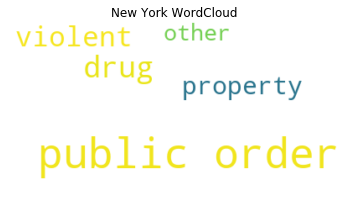

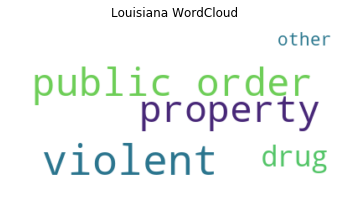

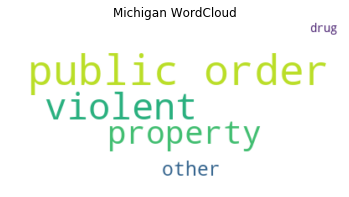

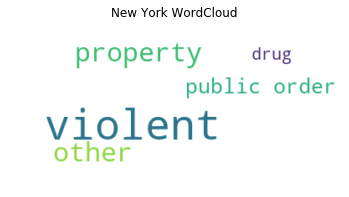

In [559]:
# plots of BJS broad category by states

cmap = cm.get_cmap('Spectral')

ar = pd.DataFrame.from_dict(AR_code_categ,orient='index',columns=['count'])
# ar.plot(kind='barh', rot=45, figsize=(7,7), subplots=True, colormap=cmap, legend={'reverse'}, title=['Arkansas'])
# ar.plot(kind='pie', rot=45, figsize=(7,7), subplots=True, colormap=cmap, legend={'reverse'}, title=['Arkansas'])

la = pd.DataFrame.from_dict(LA_code_categ,orient='index',columns=['count'])
# la.plot(kind='barh', rot=45, figsize=(7,7), subplots=True, colormap=cmap, legend={'reverse'}, title=['Arkansas'])
# la.plot(kind='pie', rot=45, figsize=(7,7), subplots=True, colormap=cmap, legend={'reverse'}, title=['Arkansas'])

mi = pd.DataFrame.from_dict(MI_code_categ,orient='index',columns=['count'])
# mi.plot(kind='barh', rot=45, figsize=(7,7), subplots=True, colormap=cmap, legend={'reverse'}, title=['Arkansas'])
# mi.plot(kind='pie', rot=45, figsize=(7,7), subplots=True, colormap=cmap, legend={'reverse'}, title=['Arkansas'])

ny = pd.DataFrame.from_dict(NY_code_categ,orient='index',columns=['count'])
# ny.plot(kind='barh', rot=45, figsize=(7,7), subplots=True, colormap=cmap, legend={'reverse'}, title=['Arkansas'])
# ny.plot(kind='pie', rot=45, figsize=(7,7), subplots=True, colormap=cmap, legend={'reverse'}, title=['Arkansas'])


# TODO: Wordcloud of BJS broad categories
wc = WordCloud(background_color="white", max_font_size=50)
wc.generate_from_frequencies(AR_code_categ)
plt.imshow(wc, interpolation='bilinear')
plt.title('New York WordCloud')
plt.axis("off")
plt.show()

wc.generate_from_frequencies(LA_code_categ)
plt.imshow(wc, interpolation='bilinear')
plt.title('Louisiana WordCloud')
plt.axis("off")
plt.show()

wc.generate_from_frequencies(MI_code_categ)
plt.imshow(wc, interpolation='bilinear')
plt.title('Michigan WordCloud')
plt.axis("off")
plt.show()

wc.generate_from_frequencies(NY_code_categ)
plt.imshow(wc, interpolation='bilinear')
plt.title('New York WordCloud')
plt.axis("off")
plt.show()


AR distribution:                Name          Bond
Race     Sex                     
Asian    F        1    365.000000
         M       51  37784.313725
Black    F      125  31878.640000
         M     1220  45462.008197
Hispanic F      123  32018.739837
         M      819  35059.065934
Indian   M       63  61593.807937
None     F       23  50000.000000
         M      174  25474.137931
         None     1    465.000000
White    F     1233  55688.309813
         M     4856  40348.444094
         None     3  10000.000000
p        M       49  37030.612245
Index(['Name', 'Age', 'Race', 'Sex', 'Eyes', 'Hair', 'Bond', 'Charge'], dtype='object')


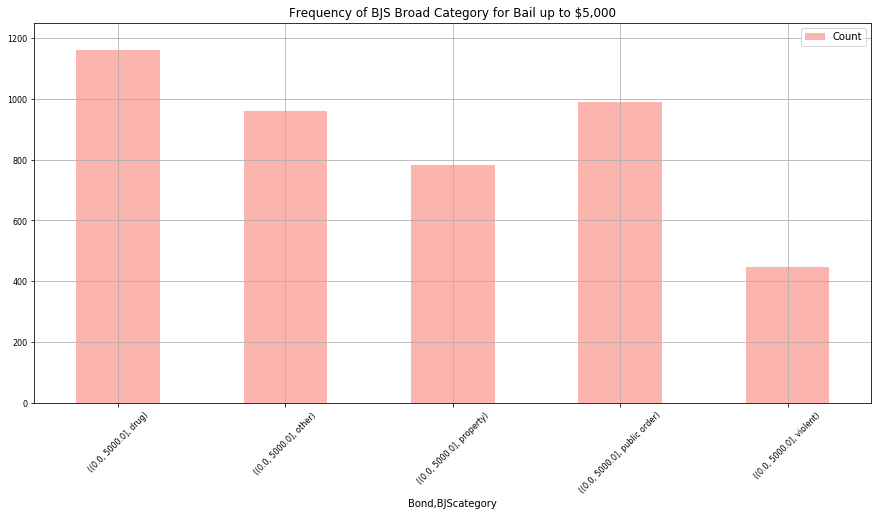

In [560]:
# [2] Arkansas
tempAR = dfArkansas2.copy()

# TODO: race, gender and age distributions (gender ratio per race)
race_gender_count = tempAR.groupby(['Race','Sex'])['Name'].count()
race_gender_bond = tempAR.groupby(['Race','Sex'])['Bond'].mean()
distAR = pd.concat([race_gender_count, race_gender_bond],axis=1).rename(columns={'Unnamed: 0':'Count'})
print("AR distribution:",distAR)

data = tempAR.Charge.str.lower()
col_to_append = []
count = 0
for charge in data:
    if charge in list(AR_charge_code.keys()):
        count += 1
        foundIdx = list(AR_charge_code.keys()).index(charge)
        AR_code =  list(AR_charge_code.values())[foundIdx]
        AR_categ = bjs_dict.get(float(AR_code))
        if AR_categ is None:
            AR_categ = 'other'
        
        col_to_append.append(AR_categ)
    else:
        col_to_append.append('other')
tempAR['BJScategory'] = col_to_append

# plot frequency of (bail bond amount and BJS category) 

cmap = cm.get_cmap('Pastel1')
# bondbins = pd.cut(tempLA['Bond_Amount'], np.linspace(0, max(tempLA['Bond_Amount']),13))
bondbins = pd.cut(tempAR['Bond'], np.linspace(0, 5000, 2))
select_by = [bondbins,'BJScategory']
grouped = tempAR.groupby(by=select_by).count()
print(grouped.columns)

# change legend (column) label to 'Count'
grouped['Count'] = grouped['Name']
grouped = grouped['Count']

# plot
grouped.plot(kind='bar', figsize=(15,7), rot=45, fontsize=8, grid=True, colormap=cmap,legend=True, ylim=(0,1250), title="Frequency of BJS Broad Category for Bail up to $5,000")
plt.show()


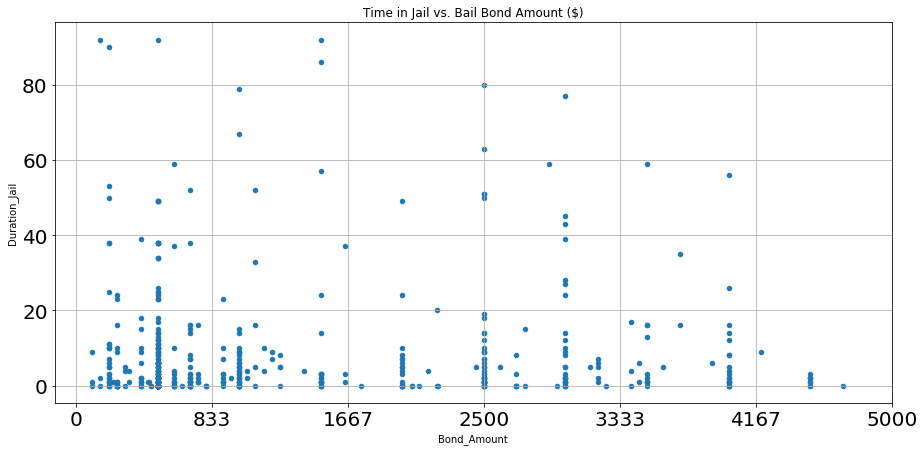

LA distribution:               Count    Bond_Amount
Race     Sex                      
Asian    F        3   30000.000000
         M        2    5000.000000
Black    F      165   29136.666667
         M     1238   66355.945880
Hispanic F        1    2500.000000
         M       31   74451.612903
None     F        2     200.000000
         M       14  136250.000000
White    F       76   48158.157895
         M      255   36926.588235
Index(['Unnamed: 0', 'Name', 'Sex', 'Duration_Jail', 'Race', 'Status',
       'Bond_Amount', 'Charge', 'Statute'],
      dtype='object')


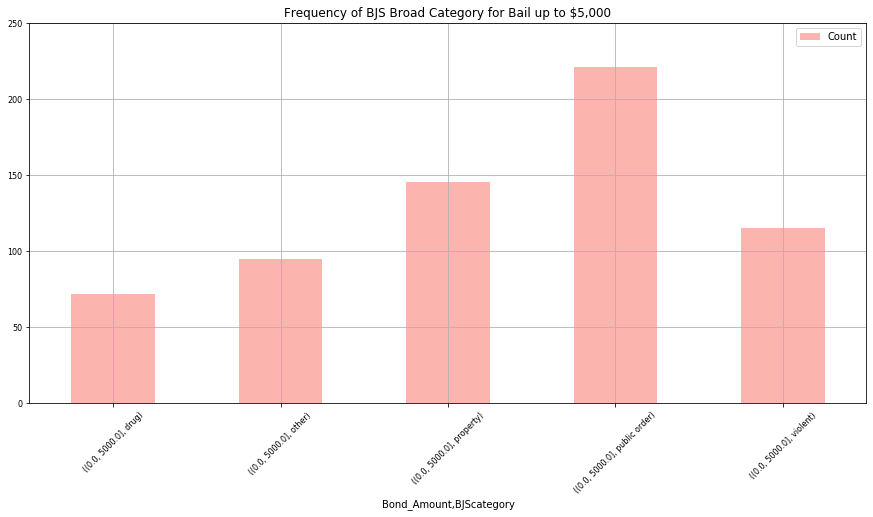

In [561]:
# [2] Louisiana 

# compute time spent in jail
from datetime import *

tempLA = dfLouisiana2.copy()
duration_jail = []
for book, release, status in zip(list(tempLA['Booking_Date']), list(tempLA['Release_Date']), list(tempLA['Status'])):
    book_tokens = book.split('-')
    if book_tokens[0] == 'None':
        bookdate = -1;  
        continue
    else:
        book_yy = int(book_tokens[0])
        book_mm = int(book_tokens[1])
        book_dd = int(book_tokens[2])
        bookdate = date(book_yy, book_mm, book_dd)
    
    release_tokens = release.split('-')
    if release_tokens[0] == 'None':        
        duration = -1
    else:
        release_yy = int(release_tokens[0])
        release_mm = int(release_tokens[1])
        release_dd = int(release_tokens[2])
        releasedate = date(release_yy, release_mm, release_dd)
        if bookdate is not -1:
            duration = releasedate - bookdate
        else:
            duration = -1
    # append value only if status is released, else -1
    if (status == 'RELEASED' and duration is not -1):
        duration_jail.append(int(duration.days))
    else:
        duration_jail.append(int(-1))

tempLA.drop(['Booking_Date','Release_Date'], axis=1, inplace=True)
tempLA.insert(3, 'Duration_Jail', pd.Series(duration_jail))
tempLA.dropna(inplace=True)

# get indexes for which column 'Duration_Jail' has invalid values, and drop them
indexInvalidDuration = tempLA[ tempLA['Duration_Jail'] == -1 ].index
tempLA.drop(indexInvalidDuration , inplace=True)

''' set fonts
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)
'''
# plot (time in jail) vs. (bail bond amount)
# cmap = cm.get_cmap('Spectral') # colormap=cmap
# data_scatter = pd.concat([tempLA.Duration_Jail, tempLA.Bond_Amount],axis=1)
# data_scatter.plot(kind='scatter',x='Bond_Amount',y='Duration_Jail',\
#                   figsize=(15,7),fontsize=10,grid=True,xticks=np.linspace(0,np.max(data_scatter.Bond_Amount),13), \
#                   title="Time in Jail vs. Bail Bond Amount")
# plt.show()

# plot (time in jail) vs. (bail bond amount), thresholded
bondmax = 5000
durationmax = 100
data_scatter = pd.concat([tempLA[tempLA['Bond_Amount']<bondmax]['Bond_Amount'], tempLA[tempLA['Duration_Jail']<durationmax]['Duration_Jail']], axis=1)
data_scatter.plot(kind='scatter',x='Bond_Amount',y='Duration_Jail',figsize=(15,7),fontsize=20,grid=True,xticks=np.linspace(0,bondmax,7), \
                  title='Time in Jail vs. Bail Bond Amount ($)')
plt.show()

# TODO: race, gender and age distributions (gender ratio per race)
race_gender_count = tempLA.groupby(['Race','Sex'])['Unnamed: 0'].count()
race_gender_bond = tempLA.groupby(['Race','Sex'])['Bond_Amount'].mean()
distLA = pd.concat([race_gender_count, race_gender_bond],axis=1).rename(columns={'Unnamed: 0':'Count'})
print("LA distribution:",distLA)

# TODO: charges and bond distributions for the above population
# font = {'family' : 'DejaVu Sans',
#         'weight' : 'bold',
#         'size'   : 10}
# matplotlib.rc('font', **font)

# TODO: convert 'Charge' description to BJS broad category and see frequency

# categorize by BJS broad categories, and append to temporary dataframe
data = tempLA.Charge.str.lower()
col_to_append = []
count = 0
for charge in data:
    if charge in list(LA_charge_code.keys()):
        count += 1
        foundIdx = list(LA_charge_code.keys()).index(charge)
        LA_code =  list(LA_charge_code.values())[foundIdx]
        LA_categ = bjs_dict.get(float(LA_code))
        if LA_categ is None:
            LA_categ = 'other'
        
        col_to_append.append(LA_categ)
    else:
        col_to_append.append('other')
tempLA['BJScategory'] = col_to_append

# plot frequency of (bail bond amount and BJS category) 

cmap = cm.get_cmap('Pastel1')
# bondbins = pd.cut(tempLA['Bond_Amount'], np.linspace(0, max(tempLA['Bond_Amount']),13))
bondbins = pd.cut(tempLA['Bond_Amount'], np.linspace(0, 5000, 2))
select_by = [bondbins,'BJScategory']
grouped = tempLA.groupby(by=select_by).count()
print(grouped.columns)

# change legend (column) label to 'Count'
grouped['Count'] = grouped['Unnamed: 0']
grouped = grouped['Count']

# plot
grouped.plot(kind='bar', figsize=(15,7), rot=45, fontsize=8, grid=True, colormap=cmap,legend=True, ylim=(0,250), title="Frequency of BJS Broad Category for Bail up to $5,000")
plt.show()


Index(['Name', 'Booking_Date', 'Booking_Time', 'Charge',
       'Charge_Classification', 'County', 'Court_Date', 'DOB', 'Disposition',
       'Docket_Number', 'Location', 'Offense_Date', 'Offense_Time',
       'Sentence_Date', 'Sentence_Length', 'Bond($)'],
      dtype='object')


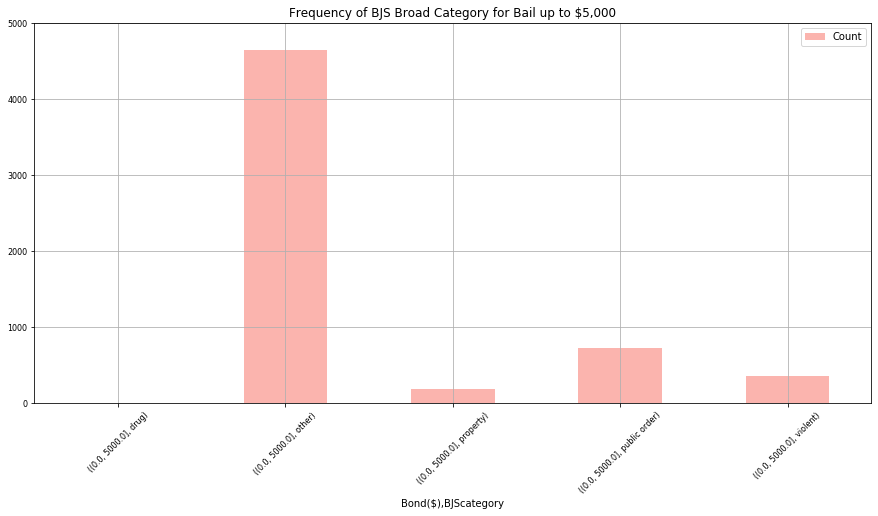

[nan, 4642.0, 190.0, 723.0, 358.0]

In [562]:
# [2] Michigan 
tempMI = dfMichigan2.copy()

# TODO: race, gender and age distributions (gender ratio per race)
# >> no demographic information is present for Michigan

# TODO: charges and bond distributions for the above population
data = tempMI.Charge.str.lower()
col_to_append = []
count = 0
# print(MI_charge_code.keys())
for charge in data:
    if charge in list(MI_charge_code.keys()):
        # print("yes! charge %s is in the keys" % charge)
        count += 1
        foundIdx = list(MI_charge_code.keys()).index(charge)
        MI_code =  list(MI_charge_code.values())[foundIdx]
        MI_categ = bjs_dict.get(float(MI_code))
        if MI_categ is None:
            MI_categ = 'other'
        col_to_append.append(MI_categ)
    else:
        col_to_append.append('other')
        
tempMI['BJScategory'] = col_to_append

# plot frequency of (bail bond amount and BJS category) 

cmap = cm.get_cmap('Pastel1')
# bondbins = pd.cut(tempLA['Bond_Amount'], np.linspace(0, max(tempLA['Bond_Amount']),13))
bondbins = pd.cut(tempMI['Bond($)'], np.linspace(0, 5000, 2))
select_by = [bondbins,'BJScategory']
grouped = tempMI.groupby(by=select_by).count()
print(grouped.columns)

# change legend (column) label to 'Count'
grouped['Count'] = grouped['Name']
grouped = grouped['Count']

# plot
grouped.plot(kind='bar', figsize=(15,7), rot=45, fontsize=8, grid=True, colormap=cmap,legend=True, ylim=(0,5000), title="Frequency of BJS Broad Category for Bail up to $5,000")
plt.show()

list(grouped)

                nysid      bond_info
race    gender                      
Asian   Male       18   92445.166667
Black   Female     38   44223.894737
        Male      926  765939.793737
Indian  Female      1   25000.000000
        Male        4   32500.000000
Other   Female     14   67499.928571
        Male      396   95408.654040
Unknown Male        2  100000.000000
White   Female     10  135700.900000
        Male      140   89621.864286
Index(['nysid', 'bond_info', 'warrants', 'arrest_date', 'next_court_date',
       'housing_facility', 'docket_numbers', 'charges', 'race', 'gender',
       'is_new', 'Unnamed: 11'],
      dtype='object')


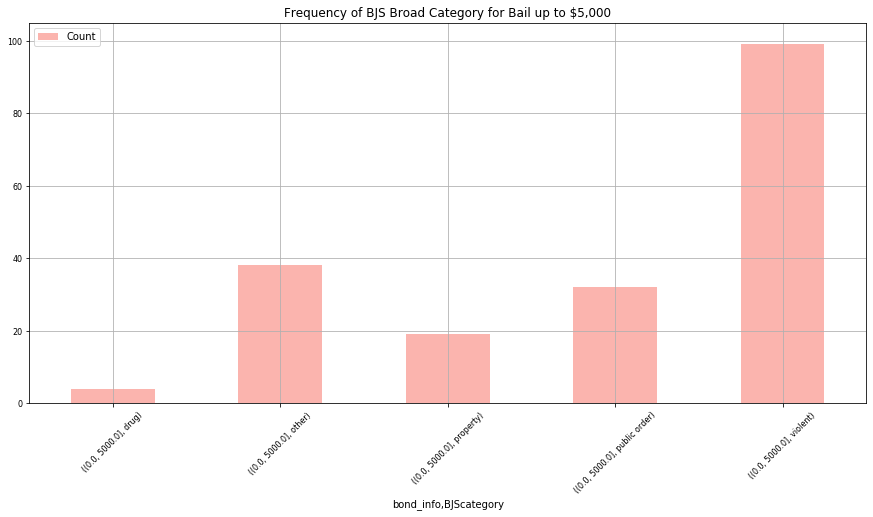

[4, 38, 19, 32, 99]

In [563]:
# [2] New York

tempNY = dfNewYork2.copy()

# TODO: race, gender distributions (gender ratio per race)
race_gender_count = tempNY.groupby(['race','gender'])['nysid'].count()
race_gender_bond = tempNY.groupby(['race','gender'])['bond_info'].mean()
distNY = pd.concat([race_gender_count, race_gender_bond],axis=1)
print(distNY)

# TODO: charges and bond distributions for the above population
data = [statute for idx,statute in NY_state_statutes]
col_to_append = []
count = 0
# print(MI_charge_code.keys())
for statute in data:
    if statute in list(NY_charge_code.keys()):
#         print("yes! statute %s is in the keys" % statute)
        count += 1
        foundIdx = list(NY_charge_code.keys()).index(statute)
        NY_code =  list(NY_charge_code.values())[foundIdx]
        NY_categ = bjs_dict.get(float(NY_code))
        if NY_categ is None:
            NY_categ = 'other'
        col_to_append.append(NY_categ)
    else:
        col_to_append.append('other')
tempNY['BJScategory'] = col_to_append

# plot frequency of (bail bond amount and BJS category) 

cmap = cm.get_cmap('Pastel1')
# bondbins = pd.cut(tempLA['Bond_Amount'], np.linspace(0, max(tempLA['Bond_Amount']),13))
bondbins = pd.cut(tempNY['bond_info'], np.linspace(0, 5000, 2))
select_by = [bondbins,'BJScategory']
grouped = tempNY.groupby(by=select_by).count()
print(grouped.columns)

# change legend (column) label to 'Count'
grouped['Count'] = grouped['nysid']
grouped = grouped['Count']

# plot
grouped.plot(kind='bar', figsize=(15,7), rot=45, fontsize=8, grid=True, colormap=cmap,legend=True, ylim=(0,105), title="Frequency of BJS Broad Category for Bail up to $5,000")
plt.show()

list(grouped)


In [564]:
# NOTE::
# when looking at the demographics, take all unique people
# when looking at the charges/cases, take all unique charge/cases

In [565]:
# TODO:
# 0 dollar bails - bond analysis
# 1 dollar bails - bond analysis